# 1 Import Packages

In [3]:
import xarray as xr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import math
import sklearn

In [4]:
keras.__version__

'2.4.3'

In [5]:
tf.__version__

'2.4.1'

# 2 Load Data

In [6]:
covariance = xr.open_dataarray("../data/covariance_2.nc")
data_input = xr.open_dataarray("../data/input_data_2.nc").isel(sample=range(10**4))
data_output = xr.open_dataarray("../data/output_data_2.nc").isel(sample=range(10**4))

data_input = data_input.stack(feature=("lat","lon"))
data_output = data_output.stack(feature=("lat","lon"))

In [7]:
label = data_output.sum(dim="feature")

In [8]:
feature_index = 22

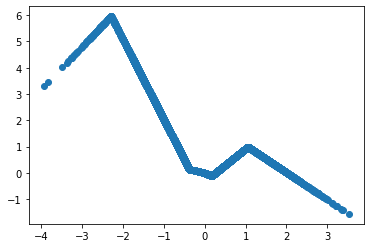

In [9]:
plt.scatter(data_input.isel(feature=feature_index),data_output.isel(feature=feature_index))

# 2 Data preprocessing

In [10]:
n_samples = data_input.sizes["sample"]
n_features = data_input.sizes["feature"]
train_test_split = 0.9

In [11]:
x_train = data_input.isel(sample=np.arange(0,int(train_test_split*n_samples)))
y_train = label.isel(sample=np.arange(0,int(train_test_split*n_samples)))

x_test = data_input.isel(sample = np.arange(int(train_test_split*n_samples),n_samples))
y_test = label.isel(sample = np.arange(int(train_test_split*n_samples),n_samples))



# 3 Linear Model Benchmark

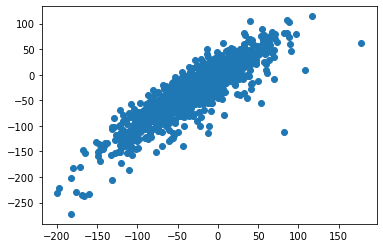

In [12]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)
y_test_prediction_linear = linear_model.predict(x_test)
plt.scatter(y_test_prediction_linear, y_test.values.flatten())

In [13]:
np.corrcoef(y_test_prediction_linear, y_test.values.flatten())

array([[1.        , 0.88382992],
       [0.88382992, 1.        ]])

# 3 Create Model

In [14]:
n_layers = 6
n_neurons = [2**(9-layer) for layer in range(n_layers)]

In [42]:
np.concatenate([[2], np.zeros(5)])

array([2., 0., 0., 0., 0., 0.])

In [55]:
n_layers = 1
n_neurons = [2**(9-layer) for layer in range(n_layers)]
regularization = np.concatenate

In [15]:
layers = []

input_layer = keras.layers.Input(shape = (n_features))
layers.append(input_layer)

layer = keras.layers.Dense(n_neurons[0], kernel_regularizer = tf.keras.regularizers.l2(10), kernel_initializer="he_normal",activation="relu")(layers[-1])
layers.append(layer)


for hidden_layer_index in range(1,n_layers):
    layer = keras.layers.Dense(n_neurons[hidden_layer_index],kernel_initializer="he_normal",activation="relu")(layers[-1])
    layers.append(layer)

output_layer = keras.layers.Dense(1, activation="linear")(layers[-1])
layers.append(output_layer)

2021-09-23 15:32:39.095383: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 15:32:39.095567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-23 15:32:39.095808: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
model = keras.models.Model(input_layer,output_layer)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 648)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               332288    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528   

In [18]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=10**(-4)), loss = "mse",metrics = ["mse"])

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [20]:
model.fit(x_train,y_train, batch_size=64, epochs=1000, validation_data=(x_test,y_test), callbacks = early_stopping_callback)

Epoch 1/1000


2021-09-23 15:33:00.829810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-23 15:33:00.851210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


141/141 [==============================] - 3s 17ms/step - loss: 13196.8179 - mse: 3829.0156 - val_loss: 7912.0044 - val_mse: 654.1620
Epoch 2/1000
141/141 [==============================] - 2s 14ms/step - loss: 7170.4830 - mse: 483.2402 - val_loss: 5574.1909 - val_mse: 368.6266
Epoch 3/1000
141/141 [==============================] - 2s 15ms/step - loss: 5118.4718 - mse: 302.9663 - val_loss: 4078.0259 - val_mse: 296.6629
Epoch 4/1000
141/141 [==============================] - 3s 18ms/step - loss: 3740.6237 - mse: 235.6348 - val_loss: 3040.5671 - val_mse: 268.4272
Epoch 5/1000
141/141 [==============================] - 2s 15ms/step - loss: 2774.2021 - mse: 197.9872 - val_loss: 2307.3162 - val_mse: 252.3611
Epoch 6/1000
141/141 [==============================] - 2s 16ms/step - loss: 2086.2657 - mse: 170.7153 - val_loss: 1783.4572 - val_mse: 237.7858
Epoch 7/1000
141/141 [==============================] - 2s 17ms/step - loss: 1593.7819 - mse: 147.4261 - val_loss: 1407.5723 - val_mse: 225.8

In [21]:
weights = model.layers[1].get_weights()[0]

In [22]:
weights_xr = xr.DataArray(weights, dims = ["feature","neuron"], coords = {"feature":x_test.coords["feature"],"neuron":range(n_neurons[0])})
weights_xr = weights_xr.unstack()

In [23]:
nrows = ncols = math.ceil(np.sqrt(n_neurons[0]))

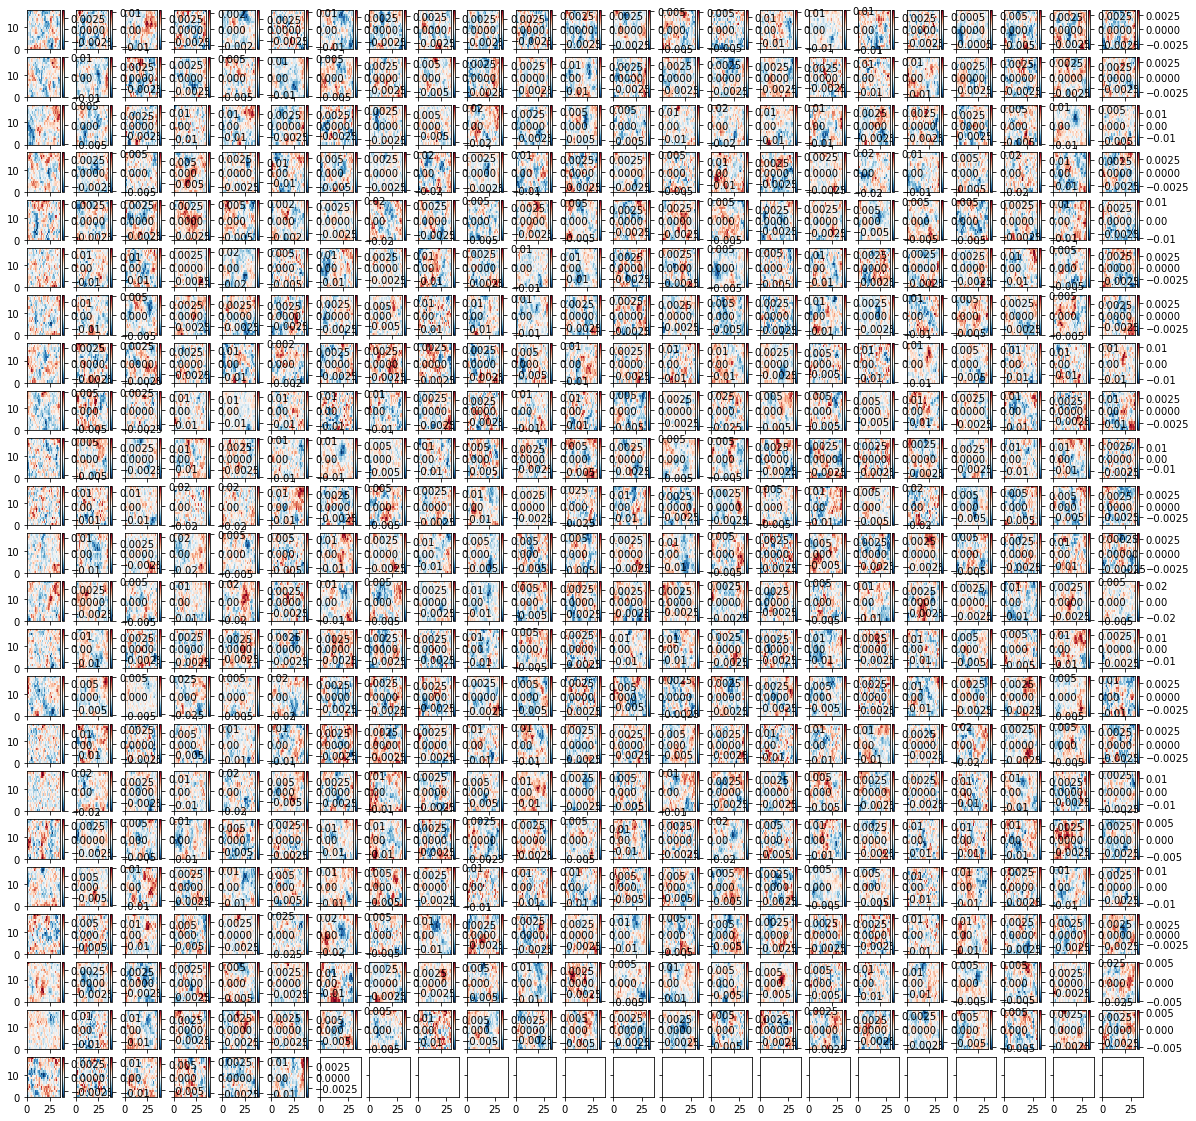

In [26]:
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20), sharex=True, sharey=True)

ax_ravel = np.ravel(ax)

for neuron_index in range(n_neurons[0]):
    tmp =weights_xr.isel(neuron=neuron_index)
    maximum = np.abs(tmp).max()
    plot = ax_ravel[neuron_index].pcolormesh(tmp, vmin=-maximum, vmax = maximum, cmap="RdBu_r")
    plt.colorbar(plot, ax = ax_ravel[neuron_index])

In [27]:
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

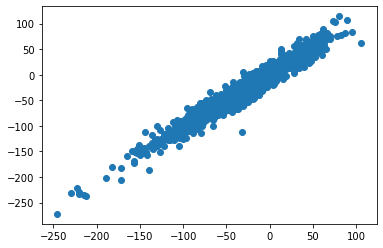

In [28]:
plt.scatter(y_test_prediction, y_test.values.flatten())

In [29]:
np.corrcoef(y_test_prediction.flatten(), y_test.values.flatten())

array([[1.        , 0.97398003],
       [0.97398003, 1.        ]])

In [30]:
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

(array([3.000e+00, 4.900e+01, 2.300e+02, 1.080e+03, 2.715e+03, 3.061e+03,
        1.459e+03, 3.410e+02, 5.500e+01, 7.000e+00]),
 array([-22.00145436, -17.73998514, -13.47851592,  -9.2170467 ,
         -4.95557748,  -0.69410826,   3.56736096,   7.82883018,
         12.0902994 ,  16.35176862,  20.61323784]),
 <BarContainer object of 10 artists>)

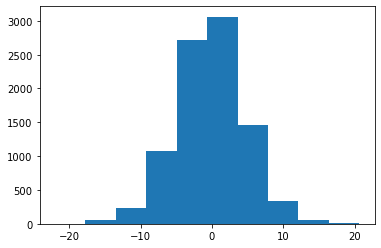

In [31]:
plt.hist(y_train_prediction.flatten()-y_train.values.flatten())

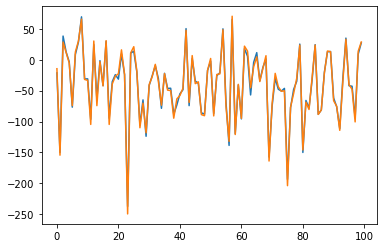

In [32]:
plt.plot(y_train_prediction[0:100])
plt.plot(y_train[0:100])

In [34]:
model.save("../data/model_3")

2021-09-23 15:41:15.342258: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [76]:
np.corrcoef (y_test_prediction.flatten(),y_test.values.flatten())

array([[1.       , 0.9014159],
       [0.9014159, 1.       ]])

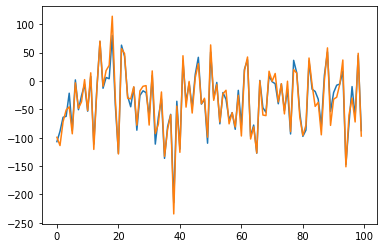

In [33]:
plt.plot(y_test_prediction[0:100])
plt.plot(y_test[0:100])

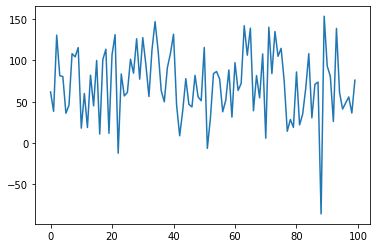

In [165]:
plt.plot(y_train[0:100])